In [106]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [107]:
import os, sys

def get_dir_n_levels_up(path, n):
    # Go up n levels from the given path
    for _ in range(n):
        path = os.path.dirname(path)
    return path

proj_root = get_dir_n_levels_up(os.path.abspath("__file__"), 4)
sys.path.append(proj_root)

import warnings
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()

warnings.filterwarnings("ignore")

from dqn.opinion_dynamics.utils.experiment import process_experiment


In [108]:
# experiment_sub_dir = "2025May02-101004_configs" # excellent run
# experiment_sub_dir = "2025Jul09-171538_configs" # good latest run
# experiment_sub_dir = "2025Sep15-090310_configs" paper run 1 finite h

# experiment_sub_dir = "2025Oct15-095412_configs" 
# experiment_sub_dir = "2025Oct16-023909_configs" # linear term state
# experiment_sub_dir = "2025Oct16-100935_configs" # coca no term state
# experiment_sub_dir = "2025Oct17-101225_configs" # coca no term state higher lr
# experiment_sub_dir = "2025Oct17-154612_configs" # coca no term state higher lr more epochs
# experiment_sub_dir = "2025Oct18-002003_configs" # coca no term state higher lr new params
# experiment_sub_dir = "2025Oct18-135551_configs" # coca no term state higher lr new params
# experiment_sub_dir = "2025Oct19-030258_configs" # coca no term state higher lr even more new params
experiment_sub_dir = "2025Oct19-182701_configs" # coca no term state higher lr even more new params


 
exp_path = os.path.join(os.path.abspath("."), "results", experiment_sub_dir)
df = process_experiment(
    exp_path
)
# df.columns


In [109]:
# df

In [110]:
# df[df['epoch_type'] == 'validation']
# df[df['epoch_type'] == 'training']

In [111]:
# Define hyperparameter columns
hyperparam_columns = [col for col in df.columns if "sub_exp_cfg" in col]

# Group by hyperparameter values and compute mean episode_rewards_mean
averaged_results = df.groupby(hyperparam_columns, as_index=False).agg({
    'episode_rewards_mean': 'mean',  # Averaging the performance metric
    'sub_experiment_path': 'first'   # Keep a reference to an experiment path
})

# Find the best hyperparameter set based on the highest mean reward
best_row = averaged_results.loc[averaged_results['episode_rewards_mean'].idxmax()]

# Print the best experiment path and hyperparameters
print(f"Best hyperparameters:\n{best_row[hyperparam_columns]}")
print(f"Best mean reward: {best_row['episode_rewards_mean']}")

Best hyperparameters:
sub_exp_cfg_estimator.model    OpinionNet
sub_exp_cfg_optim.args_.lr         0.0001
sub_exp_cfg_experiment          fixed_res
Name: 0, dtype: object
Best mean reward: -23.28581630505937


In [112]:
averaged_results

,sub_exp_cfg_estimator.model,sub_exp_cfg_optim.args_.lr,sub_exp_cfg_experiment,episode_rewards_mean,sub_experiment_path
0,OpinionNet,0.0001,fixed_res,-23.285816,d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...
1,OpinionNet,5e-05,fixed_res,-23.390321,d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...
2,OpinionNetCommonAB,0.0001,fixed_res,-27.253372,d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...
3,OpinionNetCommonAB,5e-05,fixed_res,-27.460659,d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...


In [113]:
# selected_metric = 'episode_rewards_mean'
# hue_col = "sub_exp_cfg_agent_params.args_.action_w_noise_amplitude"

# # Filter for validation episodes
# validation_df = df[df['epoch_type'] == 'validation']

# # Get the unique sorted frame_stamp values
# unique_frames = np.sort(validation_df['frame_stamp'].unique())
# N = 1
# # Get all frame_stamp values after the first N unique ones
# filtered_frames = unique_frames[N:]

# # Filter the DataFrame to only include rows with these frame_stamp values
# filtered_df = validation_df[validation_df['frame_stamp'].isin(filtered_frames)]

# plt.figure(figsize=(10, 6))
# sns.lineplot(data=filtered_df, x='frame_stamp', y=selected_metric, hue=hue_col)
# plt.ylabel(selected_metric)
# plt.xlabel('Frame Stamp')
# plt.show()

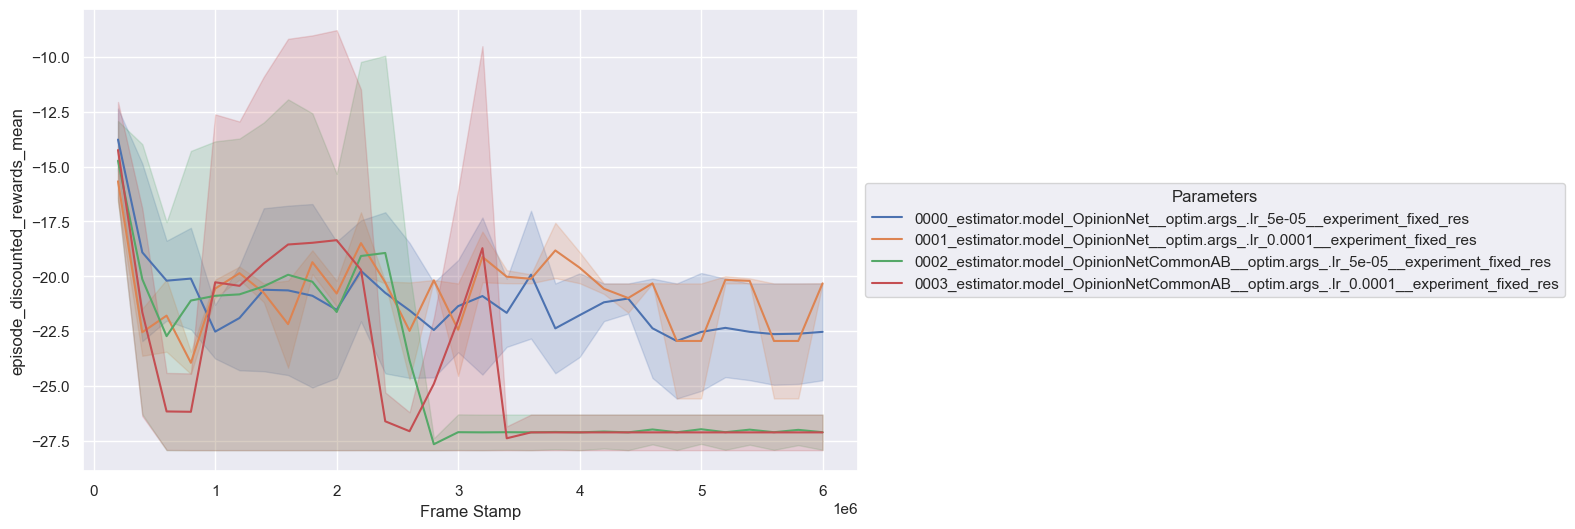

In [114]:

selected_metric = 'episode_discounted_rewards_mean'
# hue_col = "sub_exp_cfg_agent_params.args_.action_w_noise_amplitude"
hue_col = "experiment_name"

validation_df = df[df['epoch_type'] == 'validation']
# validation_df = df[df['epoch_type'] == 'training']


# Create a new figure for each environment
plt.figure(figsize=(10, 6))
# sns.lineplot(data=df, x='frame_stamp', y=selected_metric, hue='model')
sns.lineplot(data=validation_df, 
             x='frame_stamp', 
             y=selected_metric, 
             hue=hue_col,
            #  units='seed', # Comment this to see mean + cf
            #  estimator=None, # Comment this to see mean + cf
             )

plt.ylabel(selected_metric)
plt.xlabel('Frame Stamp')

# Place the legend outside the plot
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), title='Parameters')
plt.show()

In [115]:
df.columns

Index(['epoch_type', 'frame_stamp', 'greedy_epsilon', 'episode_rewards_min',
       'episode_rewards_max', 'episode_rewards_mean', 'episode_rewards_median',
       'episode_rewards_std', 'episode_discounted_rewards_min',
       'episode_discounted_rewards_max', 'episode_discounted_rewards_mean',
       'episode_discounted_rewards_median', 'episode_discounted_rewards_std',
       'episode_frames_min', 'episode_frames_max', 'episode_frames_mean',
       'episode_frames_median', 'episode_frames_std', 'episode_losses_min',
       'episode_losses_max', 'episode_losses_mean', 'episode_losses_median',
       'episode_losses_std', 'episode_max_qs_min', 'episode_max_qs_max',
       'episode_max_qs_mean', 'episode_max_qs_median', 'episode_max_qs_std',
       'policy_trained_times', 'target_trained_times', 'epoch_time',
       'sub_exp_cfg_estimator.model', 'sub_exp_cfg_optim.args_.lr',
       'sub_exp_cfg_experiment', 'sub_experiment_path', 'seed',
       'experiment_name'],
      dtype='object'

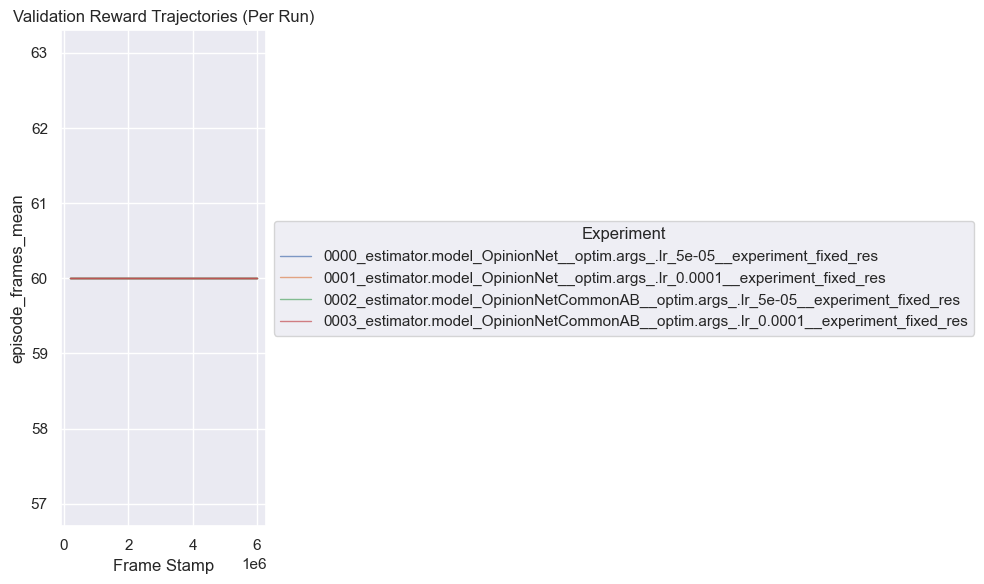

In [116]:
import matplotlib.pyplot as plt
import seaborn as sns

selected_metric = 'episode_frames_mean'
hue_col = "experiment_name"  # or another distinguishing column like "sub_experiment_path"

validation_df = df[df['epoch_type'] == 'validation']

# Plot individual lines for each run
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=validation_df,
    x='frame_stamp',
    y=selected_metric,
    hue=hue_col,
    estimator=None,  # ← disables aggregation
    units='sub_experiment_path',  # ← groups lines by unique run
    lw=1,  # line width
    alpha=0.7  # transparency
)

plt.ylabel(selected_metric)
plt.xlabel('Frame Stamp')
plt.title('Validation Reward Trajectories (Per Run)')

# Move legend outside the plot
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), title='Experiment')
plt.tight_layout()
plt.show()


In [117]:
### Select data

experiment_columns = [
    'epoch_type', 'frame_stamp',
    'episode_rewards_mean', 'episode_frames_mean', 
    'episode_discounted_rewards_mean',
    'policy_trained_times', 'target_trained_times', 'epoch_time', 
       'seed', 'experiment_name', "sub_experiment_path"
]
hyperparam_columns = [
   col for col in df.columns if "sub_exp_cfg" in col
]

cols_of_interest = experiment_columns + hyperparam_columns

sub_df = df[cols_of_interest]
sub_df = sub_df[sub_df['epoch_type'] == 'validation']
sub_df = sub_df[sub_df['frame_stamp'] == sub_df['frame_stamp'].max()]

sub_df 


,epoch_type,frame_stamp,episode_rewards_mean,episode_frames_mean,episode_discounted_rewards_mean,policy_trained_times,target_trained_times,epoch_time,seed,experiment_name,sub_experiment_path,sub_exp_cfg_estimator.model,sub_exp_cfg_optim.args_.lr,sub_exp_cfg_experiment
59,validation,6000000,-32.169190,60.0,-24.736427,NaN,NaN,0 days 00:00:08.214247,0,0000_estimator.model_OpinionNet__optim.args_.l...,d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,OpinionNet,5e-05,fixed_res
119,validation,6000000,-25.810810,60.0,-20.327592,NaN,NaN,0 days 00:00:07.665251,1,0000_estimator.model_OpinionNet__optim.args_.l...,d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,OpinionNet,5e-05,fixed_res
179,validation,6000000,-25.625859,60.0,-20.316458,NaN,NaN,0 days 00:00:07.960816,0,0001_estimator.model_OpinionNet__optim.args_.l...,d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,OpinionNet,0.0001,fixed_res
239,validation,6000000,-25.810810,60.0,-20.327592,NaN,NaN,0 days 00:00:07.709733,1,0001_estimator.model_OpinionNet__optim.args_.l...,d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,OpinionNet,0.0001,fixed_res
299,validation,6000000,-34.367411,60.0,-26.300723,NaN,NaN,0 days 00:00:09.612039,0,0002_estimator.model_OpinionNetCommonAB__optim...,d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,OpinionNetCommonAB,5e-05,fixed_res
359,validation,6000000,-36.800100,60.0,-27.906163,NaN,NaN,0 days 00:00:10.099313,1,0002_estimator.model_OpinionNetCommonAB__optim...,d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,OpinionNetCommonAB,5e-05,fixed_res
419,validation,6000000,-34.367411,60.0,-26.300723,NaN,NaN,0 days 00:00:09.046934,0,0003_estimator.model_OpinionNetCommonAB__optim...,d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,OpinionNetCommonAB,0.0001,fixed_res
479,validation,6000000,-36.822324,60.0,-27.921264,NaN,NaN,0 days 00:00:08.290012,1,0003_estimator.model_OpinionNetCommonAB__optim...,d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,OpinionNetCommonAB,0.0001,fixed_res


In [118]:
agg_cols = [col for col in sub_df.columns if "sub_exp_cfg" in col]
aggregated_df = (
    sub_df.groupby(agg_cols)
    .agg(episode_discounted_rewards_mean=("episode_discounted_rewards_mean", "mean"))
    .reset_index()
)
aggregated_df

,sub_exp_cfg_estimator.model,sub_exp_cfg_optim.args_.lr,sub_exp_cfg_experiment,episode_discounted_rewards_mean
0,OpinionNet,0.0001,fixed_res,-20.322025
1,OpinionNet,5e-05,fixed_res,-22.532010
2,OpinionNetCommonAB,0.0001,fixed_res,-27.110993
3,OpinionNetCommonAB,5e-05,fixed_res,-27.103443


In [119]:
sub_df.columns

Index(['epoch_type', 'frame_stamp', 'episode_rewards_mean',
       'episode_frames_mean', 'episode_discounted_rewards_mean',
       'policy_trained_times', 'target_trained_times', 'epoch_time', 'seed',
       'experiment_name', 'sub_experiment_path', 'sub_exp_cfg_estimator.model',
       'sub_exp_cfg_optim.args_.lr', 'sub_exp_cfg_experiment'],
      dtype='object')

In [120]:
print(sub_df[sub_df['episode_rewards_mean'] == sub_df['episode_rewards_mean'].max()]['sub_experiment_path'].values[0])


d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dynamics\experiments\results\2025Oct19-182701_configs\0001_estimator.model_OpinionNet__optim.args_.lr_0.0001__experiment_fixed_res\0


In [121]:
sub_df[sub_df['episode_rewards_mean'] == sub_df['episode_rewards_mean'].max()]


,epoch_type,frame_stamp,episode_rewards_mean,episode_frames_mean,episode_discounted_rewards_mean,policy_trained_times,target_trained_times,epoch_time,seed,experiment_name,sub_experiment_path,sub_exp_cfg_estimator.model,sub_exp_cfg_optim.args_.lr,sub_exp_cfg_experiment
179,validation,6000000,-25.625859,60.0,-20.316458,NaN,NaN,0 days 00:00:07.960816,0,0001_estimator.model_OpinionNet__optim.args_.l...,d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,OpinionNet,0.0001,fixed_res


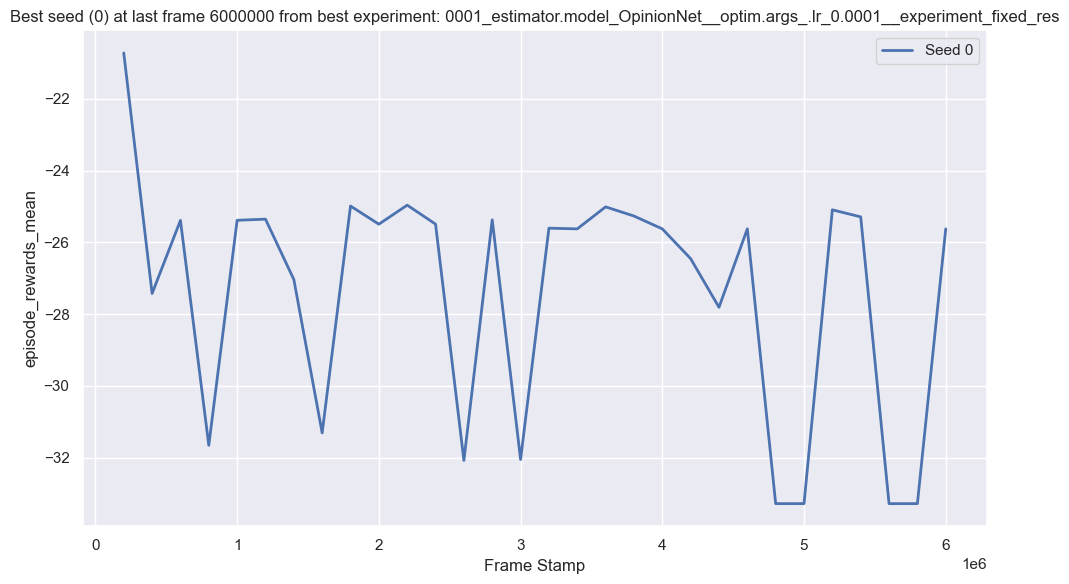

In [122]:
selected_metric = 'episode_rewards_mean'
hue_col = 'experiment_name'

val_df = df[df['epoch_type'] == 'validation'].copy()

# 1) Last global frame
last_frame = val_df['frame_stamp'].max()
last_df = val_df[val_df['frame_stamp'] == last_frame]

# 2) Best experiment by mean at LAST frame (averaged across seeds)
best_experiment = last_df.groupby(hue_col)[selected_metric].mean().idxmax()

# 3) Within that experiment, the best seed at LAST frame
best_seed = (last_df[last_df[hue_col] == best_experiment]
             .groupby('seed')[selected_metric].mean()
             .idxmax())

# 4) Plot the whole curve for that experiment+seed (not just the final point)
best_seed_df = val_df[(val_df[hue_col] == best_experiment) & (val_df['seed'] == best_seed)]

plt.figure(figsize=(10, 6))
sns.lineplot(
    data=best_seed_df,
    x='frame_stamp',
    y=selected_metric,
    lw=2,
    label=f"Seed {best_seed}"
)
plt.title(f"Best seed ({best_seed}) at last frame {last_frame} from best experiment: {best_experiment}")
plt.ylabel(selected_metric)
plt.xlabel('Frame Stamp')
plt.legend()
plt.tight_layout()
plt.show()

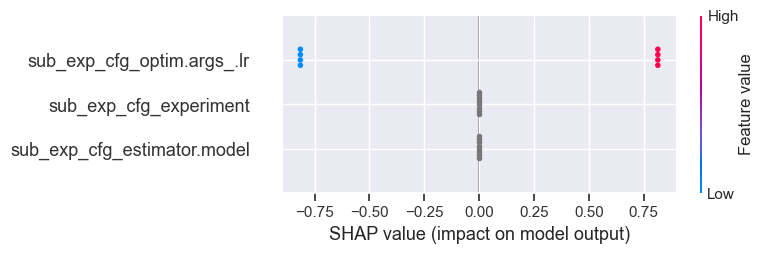

In [123]:
import shap
import xgboost
import pandas as pd


# Define the target metric and hyperparameter columns
target_metric = "episode_rewards_mean"  # Replace with actual metric column name
# Replace with actual hyperparameter column names

# Prepare data
X = sub_df[hyperparam_columns].apply(pd.to_numeric, errors='coerce')
y = sub_df[target_metric].fillna(3 * sub_df[target_metric].min())

# Train an XGBoost model to analyze feature importance
model = xgboost.XGBRegressor(objective="reg:squarederror", n_estimators=100, random_state=42)
model.fit(X, y)

# SHAP analysis
explainer = shap.Explainer(model)
shap_values = explainer(X)

# Summary plot (feature importance)
shap.summary_plot(shap_values, X)

In [124]:
# Minimal cell to PRINT compact SHAP data you can paste back here

import numpy as np
import pandas as pd

# Use the same X and shap_values from your previous cell
X_num = X.apply(pd.to_numeric, errors="coerce").fillna(X.median(numeric_only=True))

# Global importance = mean(|SHAP|) per feature
sv = shap_values
vals = sv.values if hasattr(sv, "values") else sv  # support both SHAP objects & raw arrays
mean_abs = np.mean(np.abs(vals), axis=0)

# Direction: correlation between SHAP value and raw feature (helps read summary plot colors)
corrs = []
for i, col in enumerate(X_num.columns):
    xcol = X_num.iloc[:, i].to_numpy()
    sval = vals[:, i]
    # robust correlation: handle constant columns or NaNs
    if np.allclose(xcol, xcol[0]) or np.all(np.isnan(xcol)):
        corrs.append(np.nan)
    else:
        c = np.corrcoef(xcol, sval)[0, 1]
        corrs.append(c)

global_df = pd.DataFrame({
    "feature": X_num.columns,
    "mean_abs_shap": mean_abs,
    "corr_sign": np.sign(corrs),   # +1 ≈ higher feature -> higher prediction; -1 opposite
    "corr_value": corrs
}).sort_values("mean_abs_shap", ascending=False)

# Keep per-row SHAP small: only top-10 features
topk = 10 if len(global_df) > 10 else len(global_df)
top_feats = global_df["feature"].head(topk).tolist()
top_idx = [X_num.columns.get_loc(f) for f in top_feats]
perrow_df = pd.DataFrame(vals[:, top_idx], columns=top_feats, index=sub_df.index)

# Also handy context
meta_df = pd.DataFrame({
    "prediction": model.predict(X_num),
    target_metric: sub_df[target_metric].values
}, index=sub_df.index)

# ---- PRINT CSV blocks you can paste here ----
print("# --- shap_global.csv ---")
print(global_df.to_csv(index=False))

print("# --- shap_values_top10.csv ---")
print(perrow_df.to_csv())

print("# --- shap_meta.csv ---")
print(meta_df.to_csv())


# --- shap_global.csv ---
feature,mean_abs_shap,corr_sign,corr_value
sub_exp_cfg_optim.args_.lr,0.81476223,1.0,1.0
sub_exp_cfg_estimator.model,0.0,,
sub_exp_cfg_experiment,0.0,,

# --- shap_values_top10.csv ---
,sub_exp_cfg_optim.args_.lr,sub_exp_cfg_estimator.model,sub_exp_cfg_experiment
59,-0.8147623,0.0,0.0
119,-0.8147623,0.0,0.0
179,0.8147623,0.0,0.0
239,0.8147623,0.0,0.0
299,-0.8147623,0.0,0.0
359,-0.8147623,0.0,0.0
419,0.8147623,0.0,0.0
479,0.8147623,0.0,0.0

# --- shap_meta.csv ---
,prediction,episode_rewards_mean
59,-32.286503,-32.16919005122475
119,-32.286503,-25.810809581070778
179,-30.656975,-25.625858997527384
239,-30.656975,-25.81080958157558
299,-32.286503,-34.367411145593444
359,-32.286503,-36.80010021086142
419,-30.656975,-34.367411145593444
479,-30.656975,-36.822324249169526



In [125]:
hyperparam_columns

['sub_exp_cfg_estimator.model',
 'sub_exp_cfg_optim.args_.lr',
 'sub_exp_cfg_experiment']

In [126]:
import plotly.express as px

# --- config ---
target_col = "episode_rewards_mean"          # your target metric
color_col  = "experiment_name"               # optional color grouping
readable_names = {
    # optional friendly names; falls back to raw column name if missing
    # "hp_raw_name": "Pretty Name",
}

# --- build plots ---
varying_hps = [hp for hp in hyperparam_columns if sub_df[hp].nunique(dropna=False) > 1]

if not varying_hps:
    print("No hyperparameters with more than one unique value — nothing to plot.")
else:
    for hp in varying_hps:
        # Rename only the current x column (leave others as-is for hover)
        x_name = readable_names.get(hp, hp)
        plot_df = sub_df.rename(columns={hp: x_name})

        fig = px.scatter(
            plot_df,
            x=x_name,
            y=target_col,
            color=color_col if color_col in plot_df.columns else None,
            hover_data=hyperparam_columns,  # handy to inspect full config per point
            title=f"{target_col} vs {x_name} (varying: {sub_df[hp].nunique(dropna=False)})",
            height=500
        )
        fig.update_traces(mode="markers", marker=dict(size=8, opacity=0.8))
        fig.update_layout(showlegend=False)
        fig.show()